# Anomaly Detection Using Auto Encoder Loss (Part 1)
This set of two notebook aims to use features from ICEWS and other data sources to detect anomalous activity within a country that may indicate a 'pre-conflict' state. 

- Here in __Part 1__, we will define a "stable" dataset and train an auto-encoder network architecture to reconstruct this data. 

- In __Part 2__, we will use the trained auto-encoder to estimate the distribution of loss on the entire "stable" dataset, and then compare this to the loss of "unstable" data going through the same autoencoder. 

The specific algorithm used in this notebook is outlined below:

1. Gather "normal" data that is identifiably non-anomoulous.
2. Train an auto encoder to reconstruct this "normal" data from a feature embedding.
3. Compute the distribution of the loss function of the auto encoder. 
5. Compute a probability threshold above which we consider data to be anomalous.
6. For new data, use the KDE to determine the probability of the auto encoder reconstruction loss for the new point.
7. High probability equates to "normal" or "non-anomalous".
8. Low Probability equates to "anomolous".

__Note:__ In my experiments with sensor data measuring vibrations leading up to machine failure, the alternative method was used and proved sufficient to detect significant anomalies several days ahead of failure. This is because the distance distribution was approximately normal, so it was easy to calculate a 95% threshold by simply counting two standard deviations away from the mean. 

## Step 0: Load and pre-process ICEWS data for select 'stable' countries. 
We will load both ICEWS data and exogenous data, combine all sources of data and apply PCA. 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import os
from pathlib import Path
from collections import OrderedDict

from sklearn import preprocessing as pre
# from sklearn.decomposition import PCA

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import datetime

from tqdm.notebook import tqdm
from util.data import get_country_df

sns.set()
plt.rcParams['figure.figsize'] = (10, 5)
NUM_WORKERS = os.cpu_count()

np.random.seed(1112)

### Get Stable Countries
The goal is to build machine intuition into what a 'stable' country looks like. To do this, we will concatenate together data from several countries that enjoy a large amount of peace and stability. We will use this data to train an auto-encoder that can re-construct event data using a smaller feature space. 

In [2]:
stable_countries = ['United States', 'United Kingdom', 'Spain', 'France', 'Sweden', 'Denmark']

stable_df = pd.DataFrame()
for c in stable_countries:
    temp_df = get_country_df(c, 'data/icews/')
    stable_df = pd.concat([stable_df, temp_df])
    
stable_df.Country.value_counts()

loading data/icews/icews_united_states_raw.parquet... done.
loading data/icews/icews_united_kingdom_raw.parquet... done.
loading data/icews/icews_spain_raw.parquet... done.
loading data/icews/icews_france_raw.parquet... done.
loading data/icews/icews_sweden_raw.parquet... done.
loading data/icews/icews_denmark_raw.parquet... done.


United States     250772
United Kingdom    126277
France             90539
Spain              23640
Sweden              6717
Denmark             3584
Name: Country, dtype: int64

In [3]:
stable_df.head(1)

,Event ID,Event Date,Source Name,Source Sectors,Source Country,Event Text,CAMEO Code,Intensity,Target Name,Target Sectors,...,Story ID,Sentence Number,Publisher,City,District,Province,Country,Latitude,Longitude,QuadClass
0,20718373,2014-01-01,Police (United States),"Government,Police",United States,Make statement,1,0.0,Julio Frenk Mora,"Medical / Health,Social",...,32504207.0,3.0,Associated Press Newswires,None,Queens County,state of New York,United States,40.6575,-73.8388,2


In [4]:
drop = ['Source Country', 'Target Country',
        'Country', 'Latitude', 'Longitude',
        'Event ID', 'Source Name', 
        'Source Sectors','Target Name', 
        'Target Sectors', 'Event Date',
        'Story ID','Sentence Number', 
        'Publisher', 'District',
        'Province', 'City']

stable_df = stable_df.drop(drop, axis=1)

Next, we want to one-hot encode 'Event Text', which tells what kind of event occured. Because there may be events in the larger dataset that do not occur in this "Stabel countries" dataset, we will pull the categorical features from the total data before encoding:

In [5]:
# Get comprehensive list of all 'Event Text' categories.
all_data = pd.read_parquet('data/icews/icews_all_raw.parquet')['Event Text'].astype('string')

In [6]:
# Use comprehensive list to fit one-hot-encoder for tranformation
ohe = pre.OneHotEncoder(sparse=False)

# Get one-hot encoded Event Text category
ohe.fit(all_data.to_numpy().reshape(-1, 1))
oh_data = ohe.transform(stable_df['Event Text'].to_numpy().reshape(-1, 1))

In [7]:
# Concatenate original data with one-hot data and drop 'Event Text'
oh_data = pd.DataFrame(data=oh_data, columns=ohe.categories_[0], index=stable_df.index)
stable_df = pd.concat([stable_df, oh_data], axis=1)
stable_df.drop(['Event Text'], axis=1, inplace=True)

In [8]:
stable_df

,CAMEO Code,Intensity,QuadClass,"Abduct, hijack, or take hostage","Accede to demands for change in institutions, regime",Accede to demands for change in leadership,Accede to demands for change in policy,Accede to demands for rights,Accede to requests or demands for political reform,Accuse,...,Use conventional military force,Use tactics of violent repression,Use unconventional violence,Use weapons of mass destruction,Veto,Violate ceasefire,Yield,fight with artillery and tanks,fight with small arms and light weapons,find guilty or liable (legally)
0,1,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3579,11,-2.0,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3580,6,6.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3581,19,-10.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3582,11,-2.0,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Step 1: Define auto-encoder architecture.
In this step we will define an auto-encoder which will transform the above data to a lower dimension embedding and attempt to reconstruct the data from this lower dimension feature space. 

In [9]:
class FCNetwork(nn.Module):
    """Fully Connected Network Class"""
    def __init__(self, n_input, layers, n_output, act=('relu', nn.ReLU())):
        """
        :param n_input: Integer. Size of input vector.
        :param layers: Tuple. containing the desired hidden layer architecture.
        :param n_output: Size of output vector.
        :param act: Tuple ('name', act_func). The first element should be a string
            describing the activation function. The second element is the activation
            function itself. Default is ``('ReLU', nn.ReLU())``.
        """
        super().__init__()
        self.input = nn.Linear(n_input, layers[0])
        self.hidden = self.init_hidden(layers, activation=act)
        self.output = nn.Linear(layers[-1], n_output)
        
    def init_hidden(self, layers, activation, dropout=0.0):

        n_layers = len(layers)
        modules = OrderedDict()
        a_name = activation[0]
            
        modules[f'{a_name}_in'] = activation[1]
        
        for i in range(n_layers - 1):
            modules[f'fc{i}'] = nn.Linear(layers[i], layers[i + 1])
            modules[f'{a_name}{i}'] = activation[1]
            modules[f'drop{i}'] = nn.Dropout(p=dropout)
            
        modules[f'{a_name}_out'] = activation[1]
        
        return nn.Sequential(modules)
            
    def forward(self, x):
        x = x.float()
        x = self.input(x)
        x = self.hidden(x)
        return self.output(x)
    

In [10]:
hidden_layers = (100, 75, 50, 75, 100)
input_size = stable_df.shape[1]
output_size = input_size
model = FCNetwork(input_size, hidden_layers, output_size)

## Step 2: Define a custom dataset and dataloader for efficient training.
Next, we will define a custom PyTorch `Dataset` extension that will couple with a `DataLoader` for efficiently parallelizing training.

In [11]:
class EventDataSet():
    def __init__(self, dataframe):
            self.data = dataframe

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        item = self.data.iloc[idx, :].to_numpy()
        return torch.tensor(item)

    def __len__(self):
        return len(self.data)       

## Step 3: Create and split ML dataset into training/testing sets.

In [12]:
# Shuffle training data and split into train/test sets:
stable_df = stable_df.sample(frac=1)
split_idx = int(len(stable_df) * .8)

train_data = EventDataSet(stable_df.iloc[:split_idx])
test_data = EventDataSet(stable_df.iloc[split_idx:])

train_loader = DataLoader(train_data, batch_size=50, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_data, batch_size=50, shuffle=True, num_workers=NUM_WORKERS)

## Step 4: Train auto-encoder to reconstruct stable data.
Next we will train our auto-encoder on stable country data. 

In [13]:
def train_encoder(model, trainload, epochs, criterion=nn.MSELoss(), optimizer=optim.Adam, lr=1e-6, testload=None):
    """
    Train auto-encoder reconstruction for given number of epochs.

    :param trainload: a DataLoader object containing training variables and targets used for training.
    :param testload: Optional. a DataLoader containing the validation set. If included, both training and
        validation loss will be tracked and can be plotted using model.plot_loss().
    :param epochs: Number of times the network will view the entire data set
    :param optimizer: Learning method. Default optim.Adam
    :param lr: Learning Rate. Default 0.003
    :param criterion: Loss function
    :return:
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f'Training model on {device}')
    model = model.to(device)
    opt = optimizer(model.parameters(), lr)

    train_loss = []
    valid_loss = []

    for e in tqdm(range(epochs)):
        running_tl = 0
        running_vl = 0
        for x in trainload:
            x = x.to(device).float()
            opt.zero_grad()
            loss = criterion(model(x), x)
            loss.backward()
            opt.step()
            running_tl += loss.item()

        if testload is not None:
            model.eval()
            with torch.no_grad():
                for x in testload:
                    x = x.to(device).float()
                    loss = criterion(model(x), x)
                    running_vl += loss.item()
                valid_loss.append(running_vl / len(testload))
            model.train()
            
        train_loss.append(running_tl / len(trainload))
    
    return train_loss, valid_loss

In [14]:
loss = train_encoder(model, train_loader, epochs=10, testload=test_loader)

Training model on cuda


<AxesSubplot:>

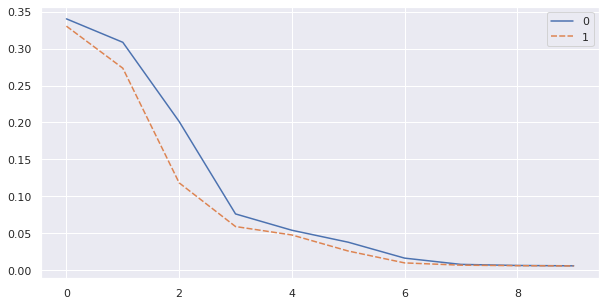

In [15]:
sns.lineplot(data=loss)

In [16]:
torch.save(model.state_dict(), 'data/models/ae1.pt')

In [17]:
loss[-1][-1]

0.00555589981342322